Please download Green taxi data for February 2016 from this site: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

**Questions:**
1. Download the data, load it into python. Report the number of rows and columns that you've loaded.
2. Visualize trip distance by time of day in any way you see fit, any observations?
3. What are the most popular pickup locations on weekends vs weekdays?
4. Build a model to forecast the number of trips by hour for the next 12 hours after Feb 12th 10:00 am. How well did you do?

I used to Google Colab and mount to my drive folder in order to get files. But if you wanna run the code, you will have to run the code below for local file upload:

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
%%capture
!pip install pyshp
# !pip install shapefile
!pip install datashader

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


import urllib.request
import zipfile
import random
import itertools
import math
import folium
from functools import partial
import datashader as ds
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
from bokeh.plotting import figure, output_notebook, show
from folium.plugins import HeatMap
from IPython.display import IFrame
from geopy.geocoders import Nominatim

First of all, import the Green taxi CSVdata for February 2016: 

In [8]:
green_taxi_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/green_tripdata_2016-02.csv')
green_taxi_df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,2.86,10.5,0.5,0.5,0.00,0.0,NaN,0.3,11.80,2,1.0
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,3.35,13.0,0.5,0.5,0.00,0.0,NaN,0.3,14.30,2,1.0
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,4.70,17.5,0.5,0.5,3.76,0.0,NaN,0.3,22.56,1,1.0
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,2.11,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1.0
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,0.98,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


## Q1. Download the data, load it into python. Report the number of rows and columns that you've loaded.

In [9]:
print('The number of rows loaded: ',green_taxi_df.shape[0])
print('The number of columns loaded: ',green_taxi_df.shape[1])

The number of rows loaded:  1510722
The number of columns loaded:  21


## Dataframe Wrangling

In [10]:
# Check datatype and missing/nan values
green_taxi_df.info(memory_usage='deep') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510722 entries, 0 to 1510721
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               1510722 non-null  int64  
 1   lpep_pickup_datetime   1510722 non-null  object 
 2   Lpep_dropoff_datetime  1510722 non-null  object 
 3   Store_and_fwd_flag     1510722 non-null  object 
 4   RateCodeID             1510722 non-null  int64  
 5   Pickup_longitude       1510722 non-null  float64
 6   Pickup_latitude        1510722 non-null  float64
 7   Dropoff_longitude      1510722 non-null  float64
 8   Dropoff_latitude       1510722 non-null  float64
 9   Passenger_count        1510722 non-null  int64  
 10  Trip_distance          1510722 non-null  float64
 11  Fare_amount            1510722 non-null  float64
 12  Extra                  1510722 non-null  float64
 13  MTA_tax                1510722 non-null  float64
 14  Tip_amount        

Removed Null values from the Data as Ehail_fee have 100% of the NULL values.

In [11]:
green_taxi_df.drop(['Ehail_fee'], axis=1,inplace=True)

Create time related features

In [12]:
green_taxi_df['lpep_pickup_datetime'] = pd.to_datetime(green_taxi_df['lpep_pickup_datetime'])
green_taxi_df['Lpep_dropoff_datetime'] = pd.to_datetime(green_taxi_df['Lpep_dropoff_datetime'])
green_taxi_df = green_taxi_df.assign(pmonth=green_taxi_df.lpep_pickup_datetime.dt.month, pday = green_taxi_df.lpep_pickup_datetime.dt.day, phour = green_taxi_df.lpep_pickup_datetime.dt.hour)

def weekday_weekend(dates):
    results = []
    for date_value in pd.DatetimeIndex(dates.values):
        weekno = date_value.weekday()
        result = "Weekday" if weekno < 5 else "Weekend"
        results.append(result)
    return results

green_taxi_df['weekday_or_weekend'] = weekday_weekend(green_taxi_df['lpep_pickup_datetime'])
green_taxi_df['day_name'] = pd.DatetimeIndex(green_taxi_df['lpep_pickup_datetime']).day_name()
daynames_with_index = {
    'Monday': '1-Monday', 'Tuesday': '2-Tuesday', 'Wednesday': '3-Wednesday', 'Thursday': '4-Thursday',
    'Friday': '5-Friday', 'Saturday': '6-Saturday', 'Sunday': '7-Sunday'
}
green_taxi_df['day_name'] = green_taxi_df['day_name'].replace(daynames_with_index)


b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
green_taxi_df['day_period'] = pd.cut(green_taxi_df['phour'], bins=b, labels=l, include_lowest=True)

green_taxi_df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type,pmonth,pday,phour,weekday_or_weekend,day_name,day_period
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,2.86,10.5,0.5,0.5,0.00,0.0,0.3,11.80,2,1.0,2,1,0,Weekday,1-Monday,Late Night
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,3.35,13.0,0.5,0.5,0.00,0.0,0.3,14.30,2,1.0,2,1,0,Weekday,1-Monday,Late Night
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,4.70,17.5,0.5,0.5,3.76,0.0,0.3,22.56,1,1.0,2,1,0,Weekday,1-Monday,Late Night
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,2.11,8.0,0.5,0.5,0.00,0.0,0.3,9.30,2,1.0,2,1,0,Weekday,1-Monday,Late Night
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,0.98,5.0,0.5,0.5,0.00,0.0,0.3,6.30,2,1.0,2,1,0,Weekday,1-Monday,Late Night


In [7]:
# green_taxi_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/green_taxi_df.csv')

Create dropoff borough (Optional)

In [154]:
# dropoff_borough = []
# for d,f in zip(green_taxi_df.Dropoff_longitude,green_taxi_df.Dropoff_latitude):
#     if ((d>=-74.040269) and (d<=-73.865036)) and ((f>=40.574031) and (f<=40.736728)):
#         dropoff_borough.append('Brooklyn')
#     elif ((d>=-74.245856) and (d<=-73.057562)) and ((f>=40.502863) and (f<=40.647234)):
#         dropoff_borough.append('Staten_island')
#     elif ((d>=-74.011645) and (d<=-73.913772)) and ((f>=40.703384) and (f<=40.876058)):
#         dropoff_borough.append('Manhattan')
#     elif ((d>=-73.931573) and (d<=-73.781473)) and ((f>=40.797766) and (f<=40.912460)):
#         dropoff_borough.append('Bronx')
#     else: dropoff_borough.append('Queens')
# Borough_dropf = pd.DataFrame(dropoff_borough,columns=['dropoff_borough'])
# green_taxi_df = pd.concat([green_taxi_df,Borough_dropf],axis=1)
# green_taxi_df.head()

Trip Distance Visualization

Skew Coefficient before preprocessing:  4.2683561115873045
Counts of Zeros 18964.


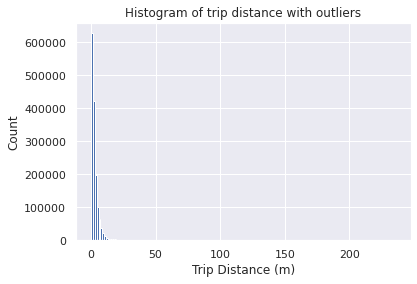

In [14]:
sns.set_theme(color_codes=True)
plt.hist(green_taxi_df.Trip_distance,bins=160)
plt.title('Histogram of trip distance with outliers')
plt.ylabel('Count')
plt.xlabel('Trip Distance (m)')
print('Skew Coefficient before preprocessing: ',green_taxi_df.Trip_distance.skew())
print(f"Counts of Zeros {green_taxi_df[green_taxi_df['Trip_distance']==0].shape[0]}.")

In [15]:
green_taxi_df['Trip_distance'].value_counts()

0.00     18964
0.90     18676
0.80     18589
1.00     18080
1.10     17015
         ...  
26.97        1
26.22        1
40.14        1
21.58        1
29.19        1
Name: Trip_distance, Length: 3066, dtype: int64

From the figure above, it implies the distance data is skewed by outliers. So we should do some preprocessing at first!


(1491758, 26)
(1473987, 26)


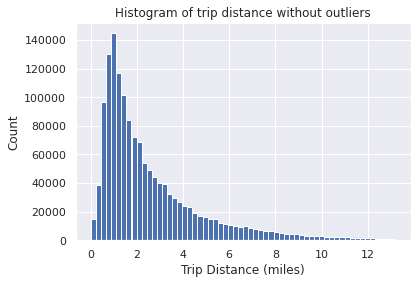

Skew Coefficient before preprocessing:  1.7698987291278616
Counts of Zeros 0


In [16]:
#Removing records in which trip distance is 0.
# Trip_Distance = green_taxi_df.Trip_distance[green_taxi_df.Trip_distance>0]
newdf = green_taxi_df[green_taxi_df.Trip_distance>0]
print(newdf.shape)
#Removing records in which trip distance is 3 standard deviations away from mean.
newdf = newdf[(newdf.Trip_distance-newdf.Trip_distance.median()).abs() < 4*newdf.Trip_distance.std()]
print(newdf.shape)
#Plotting histogram with 40 bins.
plt.hist(newdf.Trip_distance,bins = 60)
plt.title('Histogram of trip distance without outliers')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.show()

print('Skew Coefficient before preprocessing: ',newdf.Trip_distance.skew())
print(f"Counts of Zeros {newdf[newdf['Trip_distance']==0].shape[0]}")

The trip distance data without outliers is defined as distance is not positive and located further than 3 standard deviations from the mean. We assume that the trips are not random, there have non-zero autocorrelation which may due to the working man behavior like rushing to work. hence the trip distance distribution is not a symmetric Gaussian distribution. 

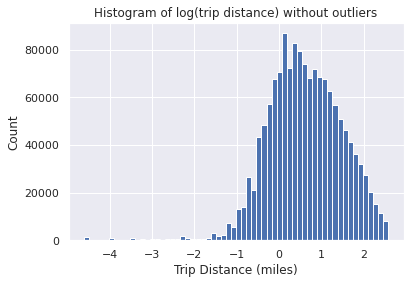

In [17]:
#Plotting histogram with 40 bins.
plt.hist(np.log(newdf.Trip_distance),bins = 60)
plt.title('Histogram of log(trip distance) without outliers')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.show()


# Q2. Visualize trip distance by time of day in any way you see fit, any observations?

### Hourly Median Trip Distance in both weekday and weekends (aka all data)

**We used the data after outlier removing from trip distance for visualization**

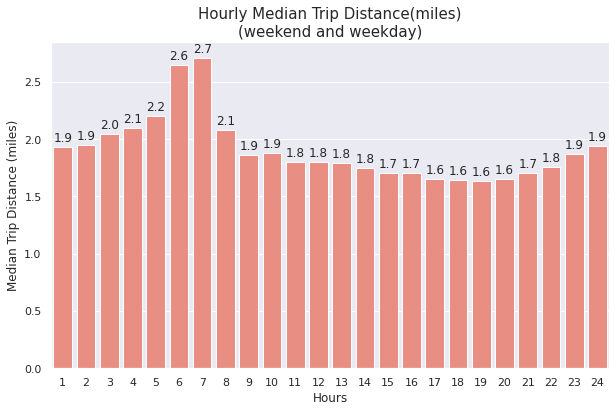

In [ ]:
hour_df = newdf.groupby(['phour'])['Trip_distance'].median().to_frame(name='MedianTD').reset_index()
hour_df['phour'] = hour_df['phour'] + 1

plt.figure(figsize=(10,6))
splot=sns.barplot(data=hour_df, x="phour", y="MedianTD",color="salmon")
# sns.lineplot(data=hour_df, x="phour", y="MedianTD")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Hourly Median Trip Distance(miles)\n(weekend and weekday)', fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=12)
plt.show();

## Observation 1: 

The median trip distance is longer at 6am and 7am than other times of the day. The overall trend of median trip distance is incresing from 1am to 7am, and then dramatically decresed to 2.1 miles at 8am. The distance is lowest during 17pm to 20pm in the time of day.


### Hourly Median Trip Distance for weekday


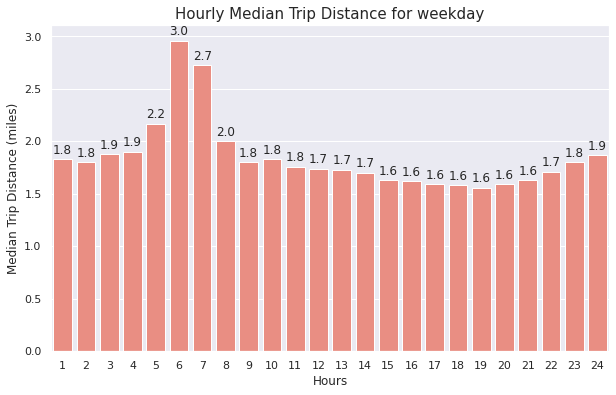

In [ ]:
newdf2 = newdf[newdf.weekday_or_weekend=='Weekday']
hour_df2 = newdf2.groupby(['phour'])['Trip_distance'].median().to_frame(name='MedianTD').reset_index()
hour_df2['phour'] = hour_df2['phour'] + 1
plt.figure(figsize=(10,6))
splot=sns.barplot(data=hour_df2, x="phour", y="MedianTD",color="salmon")
# sns.lineplot(data=hour_df, x="phour", y="MedianTD")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Hourly Median Trip Distance for weekday', fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=12)
plt.show();

## Observation 2:

Similar with the graph above, people takes green taxi for the longer median trip distance at 6am and 7am. And people takes taxi with the longest trip distance at 6am. Because this graph used the weekday trip distance data, my thinking is that most taxi are used for commuting to work which starting at near 8am. What's more, people who tend to commute by taxi should be living further from their company location. Regarding the slightly longer trip distance at 6am compared to 7am, I think it's due to more people take taxi at 6am to work than at 7am.

It's obvious that the shorter trip distance during 1am to 5am and 15am to 21am may due to less people go to work by green taxi before go to work and after duty. But it's interesting that how do people get back home? Maybe they will take vehicles or transportation that are cheaper than green taxi.

The evening peak is shorter than the morning peak, I suspect that people like to take taxes to work in order to avoid being late.

### Hourly Median Trip Distance for weekend

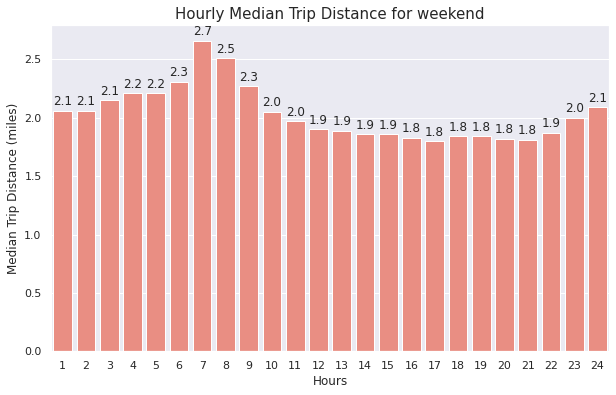

In [ ]:
newdf3 = newdf[newdf.weekday_or_weekend=='Weekend']
hour_df3 = newdf3.groupby(['phour'])['Trip_distance'].median().to_frame(name='MedianTD').reset_index()
hour_df3['phour'] = hour_df3['phour'] + 1
plt.figure(figsize=(10,6))
splot=sns.barplot(data=hour_df3, x="phour", y="MedianTD",color="salmon")
# sns.lineplot(data=hour_df, x="phour", y="MedianTD")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Hourly Median Trip Distance for weekend', fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=12)
plt.show();

## Observation 3:
Here we visualize the median trip distance on weekend. It's noticed that the longer trip distance happens at 7am and 8am, and 7am has the longest median trip distance on weekend and its median trip distance is smaller than highest distance on weekday.

I also noticed that the difference between the longer median trip distance at 7am and 8am and the rest of the data is not as significantly large as for the weekends. My assumptions are as following:

- People don't have to commute to work at early morning on weekends. Hence, the peak of hourly median trip distance is shifted one hour later than that of weekdays.

- The lower median trip distances on weekends are commonly higher than that on weekdays. I think people would be taking part in some kind of recreations on weekends,therefore, they may stay late outside in the evening, go to airport for traveling or working, shopping or having a picnic in the afternoon, and then take green taxi to go back home. 

### Comparison between hourly median trip distance in weekday and weekend 


In [ ]:
# hour_df2['weekend_or_weekday'] = 'Weekday'
# hour_df3['weekend_or_weekday'] = 'Weekend'

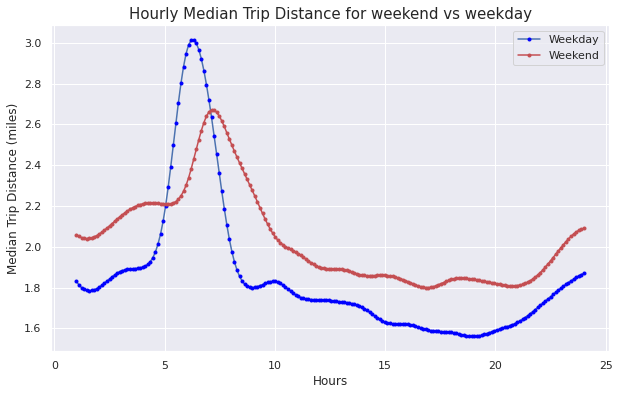

In [ ]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
from scipy.interpolate import make_interp_spline, BSpline
sns.set(context='notebook', style='darkgrid', font_scale=1)
plt.figure(figsize=(10,6))
#create data
x = hour_df2['phour']
y = hour_df2['MedianTD']
x1 = hour_df3['phour']
y1 = hour_df3['MedianTD']
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 
xnew1 = np.linspace(x1.min(), x1.max(), 200) 
#define spline
spl = make_interp_spline(x, y, k=3)
spl1 = make_interp_spline(x1, y1, k=3)
y_smooth = spl(xnew)
y_smooth1 = spl1(xnew1)
#create smooth line chart 
plt.plot(xnew, y_smooth,marker='o',markersize=3,markerfacecolor='blue',
         markeredgecolor='blue',label='Weekday')
plt.plot(xnew1, y_smooth1,'ro-',markersize=3,label='Weekend')
plt.title('Hourly Median Trip Distance for weekend vs weekday', fontsize=15)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=12)
plt.legend()
plt.show()

In [ ]:
"""
Local Regression (LOESS) estimation routine.
"""
import numpy as np
import pandas as pd
import scipy


def loc_eval(x, b):
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)



def loess(xvals, yvals, alpha, poly_degree=1):
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

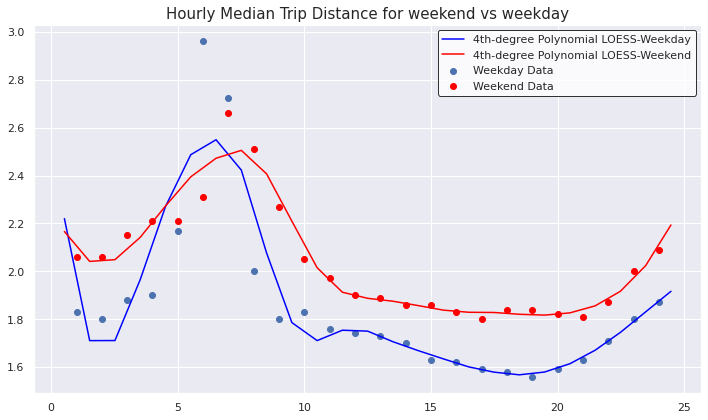

In [ ]:

sns.set(context='notebook', style='darkgrid', font_scale=1)

x = hour_df2['phour']
y = hour_df2['MedianTD']
x1 = hour_df3['phour']
y1 = hour_df3['MedianTD']
regsDF, evalDF = loess(x, y, alpha=.6, poly_degree=4)
regsDF1, evalDF1 = loess(x1, y1, alpha=.6, poly_degree=4)
# Obtain reference to LOESS x & y values (v & g).
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
l_x1  = evalDF1['v'].values
l_y1  = evalDF1['g'].values
# Generate x-y scatterplot with loess estimate overlaid.
plt.figure(figsize=(10,6))

plt.scatter(x, y, label="Weekday Data")
plt.plot(l_x, l_y, color='blue', label="4th-degree Polynomial LOESS-Weekday")
plt.scatter(x1, y1, color='red',label="Weekend Data")
plt.plot(l_x1, l_y1, color='red',label="4th-degree Polynomial LOESS-Weekend")
plt.title('Hourly Median Trip Distance for weekend vs weekday', fontsize=15)
plt.legend(loc="upper right",
           scatterpoints=1,
           fontsize=11,
           frameon=True,
           fancybox=True,
           facecolor="#FFFFFF",
           edgecolor="#000000")
plt.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(10,8))
# sns.boxplot(y='Trip_distance', x='day_period', 
#                  data=newdf, 
#                  palette="colorblind")
# plt.title('Hourly Trip Distance Box Plot(m)', fontsize=15)
# plt.xlabel('',)
# plt.ylabel('Trip Distance (m)', fontsize=12)
# plt.show();

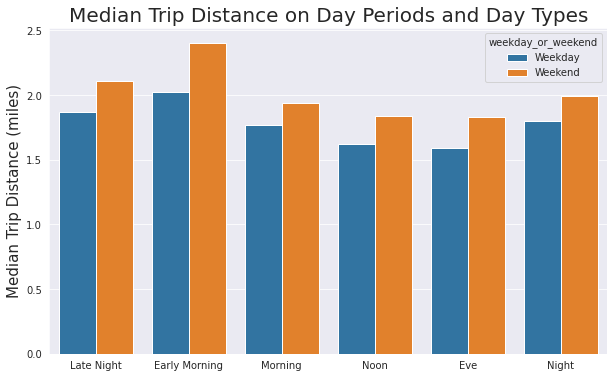

In [ ]:
dayp_df = newdf.groupby(['day_period','weekday_or_weekend']).agg({'Trip_distance':'median'}).reset_index()

plt.figure(figsize=(10,6))
# plt.bar(dayp_df.day_period, dayp_df.Trip_distance, color ='weekday_or_weekend',  
#         width = 0.4) 
ax = sns.barplot(x="day_period", y="Trip_distance", hue="weekday_or_weekend", data=dayp_df)
ax.set_alpha(0.8)
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.set_title("Median Trip Distance on Day Periods and Day Types", fontsize=20)
ax.set_ylabel("Median Trip Distance (miles)", fontsize=15)
plt.show();

## Observation 4:
It shows median trip tends to be longer on weekends than on weekdays. And overall, the longest trip is in the early morning period.

# Q3: What are the most popular pickup locations on weekends vs weekdays?

### Remove outliers in Location: Remove longitude & latitide that have 0s

In [18]:
green_taxi_df.groupby(['Pickup_longitude', 'Pickup_latitude'])["lpep_pickup_datetime"].count()

Pickup_longitude  Pickup_latitude
-115.282494       36.274498             1
-115.222740       36.096207             1
-115.190063       36.101452             1
-115.188599       36.086391             1
-115.187881       36.116478             1
                                     ... 
-71.070213        42.324272             1
-71.070206        42.324272             1
-71.070145        42.324352             1
 0.000000         0.000000           2567
                  40.745869             1
Name: lpep_pickup_datetime, Length: 1321144, dtype: int64

In [19]:
indexNames = green_taxi_df[(green_taxi_df['Pickup_longitude']==0) & (green_taxi_df['Pickup_latitude']==0)].index
# Delete these row indexes from dataFrame
clean_locdf = green_taxi_df.drop(indexNames)
index2 = clean_locdf[clean_locdf['Pickup_longitude']==0].index
clean_locdf.drop(index2,inplace=True)
clean_locdf.groupby(['Pickup_longitude', 'Pickup_latitude'])["lpep_pickup_datetime"].count()

Pickup_longitude  Pickup_latitude
-115.282494       36.274498          1
-115.222740       36.096207          1
-115.190063       36.101452          1
-115.188599       36.086391          1
-115.187881       36.116478          1
                                    ..
-71.901772        41.379814          1
-71.070244        42.324158          1
-71.070213        42.324272          1
-71.070206        42.324272          1
-71.070145        42.324352          1
Name: lpep_pickup_datetime, Length: 1321142, dtype: int64

In [11]:
clean_locdf.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type ', 'pmonth', 'pday', 'phour',
       'weekday_or_weekend', 'day_name', 'day_period'],
      dtype='object')

In [155]:
# # Save cleaned file
# clean_locdf.to_csv('/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/clean_df')

### Weekend Popular Pickup Locations:

In [20]:

weekend = clean_locdf[clean_locdf.weekday_or_weekend=='Weekend']
weekend = weekend.round({"Pickup_longitude":3, "Pickup_latitude":3}) 
weekend=weekend.groupby(['Pickup_longitude', 'Pickup_latitude'])["lpep_pickup_datetime"].count().to_frame()
top5_weekend = weekend.sort_values(by=['lpep_pickup_datetime'],ascending=False).head(5)
top5_weekend.rename(columns = {'lpep_pickup_datetime':'Counts'}, inplace = True) 
top5_weekend.reset_index(inplace=True)
top5_weekend

,Pickup_longitude,Pickup_latitude,Counts
0,-73.891,40.747,6471
1,-73.844,40.721,5252
2,-73.939,40.805,4792
3,-73.958,40.722,4512
4,-73.958,40.718,2770


In [23]:
def check_borough(df):
  pickup_borough = []
  for j,k in zip(df.Pickup_longitude,df.Pickup_latitude):
      if ((j>=-74.040269) and (j<=-73.865036)) and ((k>=40.574031) and (k<=40.736728)):
          pickup_borough.append('Brooklyn')
      elif ((j>=-74.245856) and (j<=-73.057562)) and ((k>=40.502863) and (k<=40.647234)):
          pickup_borough.append('Staten_island')
      elif ((j>=-74.011645) and (j<=-73.913772)) and ((k>=40.703384) and (k<=40.876058)):
          pickup_borough.append('Manhattan')
      elif ((j>=-73.931573) and (j<=-73.781473)) and ((k>=40.797766) and (k<=40.912460)):
          pickup_borough.append('Bronx')
      else: pickup_borough.append('Queens')
  Borough_df = pd.DataFrame(pickup_borough,columns=['pickup_borough'])
  top5_df = pd.concat([df,Borough_df], axis=1)
  return top5_df

In [93]:
top5_weekend2 = check_borough(top5_weekend)

geolocator = Nominatim(user_agent="myGeocoder")
address_list = []
for i in range(top5_weekend2.shape[0]):
  location = geolocator.reverse("{},{}".format(top5_weekend2.Pickup_latitude[i],top5_weekend2.Pickup_longitude[i]))
  address = location.address
  address_list.append(address)

top5_weekend2['Address'] = pd.Series(address_list)
top5_weekend2

,Pickup_longitude,Pickup_latitude,Counts,geometry,pickup_borough,Address
0,-73.891,40.747,6471,POINT (-73.89100 40.74700),Queens,Jackson Heights 74th Street - Roosevelt Avenue...
1,-73.844,40.721,5252,POINT (-73.84400 40.72100),Queens,"107-34, 71st Avenue, Queens, Queens County, Ne..."
2,-73.939,40.805,4792,POINT (-73.93900 40.80500),Manhattan,"East 125th Street, East Harlem, Manhattan Comm..."
3,-73.958,40.722,4512,POINT (-73.95800 40.72200),Brooklyn,"82, Wythe Avenue, Greenpoint, Brooklyn, Kings ..."
4,-73.958,40.718,2770,POINT (-73.95800 40.71800),Brooklyn,"160, North 7th Street, Williamsburg, Brooklyn,..."


In [18]:

m = folium.Map(width=1000,height=500,location=[40.75,-73.96],tiles='openstreetmap',zoom_start=12)

#location=location[0:2000]
for lat,lon in zip(top5_weekend2['Pickup_latitude'],top5_weekend2['Pickup_longitude']):
    folium.CircleMarker([lat, lon],
                          color='b',
                          fill=True,
                          fill_opacity=0.7
                          ).add_to(m)
m

In [19]:
from folium.plugins import MarkerCluster
locations = top5_weekend2[['Pickup_latitude', 'Pickup_longitude']]
locationlist = locations.values.tolist()
map = folium.Map(width=1000,height=500,location=[40.75,-73.96],tiles='openstreetmap',zoom_start=12)
marker_cluster = MarkerCluster().add_to(map)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=top5_weekend2['pickup_borough'][point]).add_to(marker_cluster)
map

**The Top 5 Weekend Pickup Locations in Feb 2016:**


1.   Jackson Heights 74th Street - Roosevelt Avenue (7), Broadway, Queens, Queens County, New York, 11373, United States: (6471 pickups)
2.   107-34, 71st Avenue, Queens, Queens County, New York, 11375, United States: (5252 pickups)
3.   East 125th Street, East Harlem, Manhattan Community Board 11, Manhattan, New York County, New York, 10035-3501, United States: (4792 pickups)
4.   82, Wythe Avenue, Greenpoint, Brooklyn, Kings County, New York, 11249, United States: (4512 pickups)
5.   160, North 7th Street, Williamsburg, Brooklyn, Kings County, New York, 11249, United States: (2770 pickups)



In [95]:
list(top5_weekend2.Address)

['Jackson Heights 74th Street - Roosevelt Avenue (7), Broadway, Queens, Queens County, New York, 11373, United States',
 '107-34, 71st Avenue, Queens, Queens County, New York, 11375, United States',
 'East 125th Street, East Harlem, Manhattan Community Board 11, Manhattan, New York County, New York, 10035-3501, United States',
 '82, Wythe Avenue, Greenpoint, Brooklyn, Kings County, New York, 11249, United States',
 '160, North 7th Street, Williamsburg, Brooklyn, Kings County, New York, 11249, United States']

### Weekday Popular Pickup Locations:

In [85]:
weekday = clean_locdf[clean_locdf.weekday_or_weekend=='Weekday']
weekday = weekday.round({"Pickup_longitude":3, "Pickup_latitude":3}) 
weekday=weekday.groupby(['Pickup_longitude', 'Pickup_latitude'])["lpep_pickup_datetime"].count().to_frame()
top5_weekday = weekday.sort_values(by=['lpep_pickup_datetime'],ascending=False).head(5)
top5_weekday.rename(columns = {'lpep_pickup_datetime':'Counts'}, inplace = True) 
top5_weekday.reset_index(inplace=True)
top5_weekday

,Pickup_longitude,Pickup_latitude,Counts
0,-73.844,40.721,13993
1,-73.939,40.805,13243
2,-73.891,40.747,12578
3,-73.952,40.790,7202
4,-73.958,40.718,6110


In [96]:
top5_weekday2 = check_borough(top5_weekday)
print(top5_weekday2.shape[0])
geolocator = Nominatim(user_agent="myGeocoder")
address_list2 = []
for i in range(top5_weekday2.shape[0]):
  location = geolocator.reverse("{},{}".format(top5_weekday2.Pickup_latitude[i],top5_weekday2.Pickup_longitude[i]))
  address = location.address
  address_list2.append(address)

top5_weekday2['Address'] = pd.Series(address_list2)
top5_weekday2

5


,Pickup_longitude,Pickup_latitude,Counts,pickup_borough,Address
0,-73.844,40.721,13993,Queens,"107-34, 71st Avenue, Queens, Queens County, Ne..."
1,-73.939,40.805,13243,Manhattan,"East 125th Street, East Harlem, Manhattan Comm..."
2,-73.891,40.747,12578,Queens,Jackson Heights 74th Street - Roosevelt Avenue...
3,-73.952,40.790,7202,Manhattan,"1465, Madison Avenue, East Harlem, Manhattan C..."
4,-73.958,40.718,6110,Brooklyn,"160, North 7th Street, Williamsburg, Brooklyn,..."


In [22]:
locations = top5_weekday2[['Pickup_latitude', 'Pickup_longitude']]
locationlist = locations.values.tolist()
map = folium.Map(width=1000,height=500,location=[40.75,-73.96],tiles='openstreetmap',zoom_start=12)
marker_cluster = MarkerCluster().add_to(map)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=top5_weekday2['pickup_borough'][point]).add_to(marker_cluster)
map

**The Top 5 Weekday Pickup Locations in Feb 2016:**


1.   107-34, 71st Avenue, Queens, Queens County, New York, 11375, United States: (13993 pickups)
2.   East 125th Street, East Harlem, Manhattan Community Board 11, Manhattan, New York County, New York, 10035-3501, United States: (13243 pickups)
3.   Jackson Heights 74th Street - Roosevelt Avenue (7), Broadway, Queens, Queens County, New York, 11373, United States: (12578 pickups)
4.   1465, Madison Avenue, East Harlem, Manhattan Community Board 11, Manhattan, New York County, New York, 10029, United States: (4512)
5.   160, North 7th Street, Williamsburg, Brooklyn, Kings County, New York, 11249, United States: (6110)

In [100]:
list(top5_weekday2.Address)

['107-34, 71st Avenue, Queens, Queens County, New York, 11375, United States',
 'East 125th Street, East Harlem, Manhattan Community Board 11, Manhattan, New York County, New York, 10035-3501, United States',
 'Jackson Heights 74th Street - Roosevelt Avenue (7), Broadway, Queens, Queens County, New York, 11373, United States',
 '1465, Madison Avenue, East Harlem, Manhattan Community Board 11, Manhattan, New York County, New York, 10029, United States',
 '160, North 7th Street, Williamsburg, Brooklyn, Kings County, New York, 11249, United States']

## Visualization of Pickup Location with highlighted trip distance

In [121]:

def plot_data_points(longitude,latitude,data_frame,focus_point) :
    #plot dimensions
    x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
    plot_width  = int(750)
    plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height,
                    x_range=x_range, y_range=y_range)
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,"NYCT_hot")

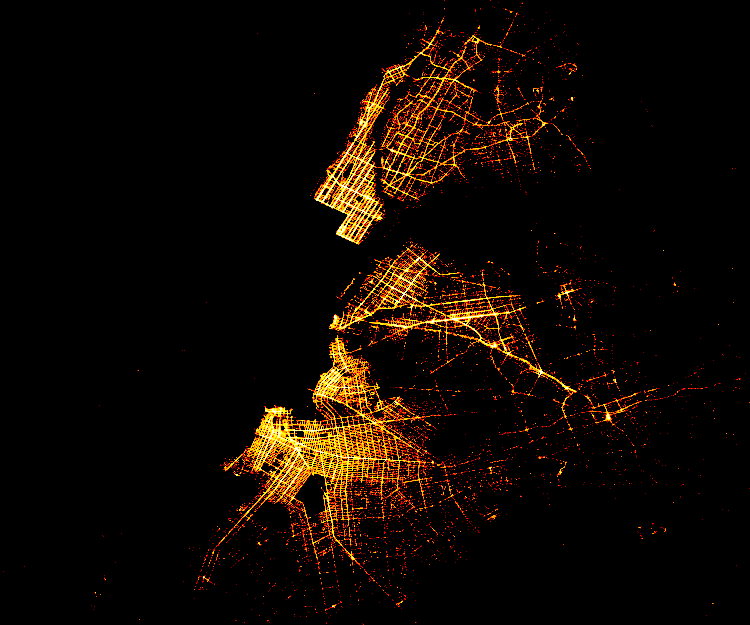

In [122]:
plot_data_points('Pickup_longitude', 'Pickup_latitude',clean_locdf,"Trip_distance")

In [ ]:
# View the map in an IFrame in ipynb file and save the map in html format
def viz_map(map,filename):
  map.save(filename)
  return IFrame(filename, width='100%', height='500px')

# Weekday Data:
weekday_pdf = pickup_df[pickup_df.weekday_or_weekend=='Weekday']


4

In [ ]:
weekday_geo = weekday_pdf.loc[weekday_pdf.weekday_or_weekend =='Weekday'][['Pickup_latitude','Pickup_longitude']]
weekday_geo.head()

,Pickup_latitude,Pickup_longitude
0,40.805214,-73.939018
1,40.746651,-73.891495
2,40.676132,-73.983780
3,40.700375,-73.807518
4,40.744934,-73.903961


In [26]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])    

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max    

## Taxi Zones Shapefile Visualization

In [27]:
sf = shapefile.Reader("/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


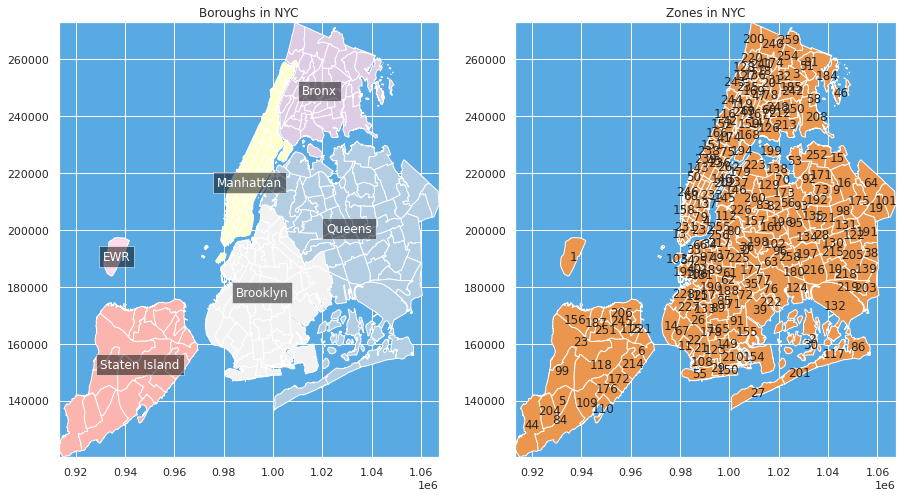

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [42]:
# sf2 = gpd.read_file(r"/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/taxi_zones/taxi_zones.shp")
# zone = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/taxi+_zone_lookup.csv")

# # Convert geometry to long/lat 
# sf2['geometry'] = sf2['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
# print(sf2.borough.unique())
# sf2.head(3)

['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn']


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
